<center>
<pre>


███████╗   ██████╗  ██╗  ██╗  ██╗  ███████╗  ███╗   ███╗
██╔════╝  ██╔════╝  ██║  ██║  ██║  ██╔════╝  ████╗ ████║
███████╗  ██║       ███████║  ██║  ███████╗  ██╔████╔██║
╚════██║  ██║       ██╔══██║  ██║  ╚════██║  ██║╚██╔╝██║
███████║  ╚██████╗  ██║  ██║  ██║  ███████║  ██║ ╚═╝ ██║
╚══════╝   ╚═════╝  ╚═╝  ╚═╝  ╚═╝  ╚══════╝  ╚═╝     ╚═╝


Semantic Classification of High-resolution Imaging for Scanned Materials
                                                                    
</pre>
</center>



# **Training**

In [1]:
# @title ## **Hyperparameters & parameters (manual setting)**
# @markdown &lArr; _**Press the triangle to run this cell after setting the parameters**_

import sys
import os
#!pip install -U -q segmentation-models --user

#os.environ["SM_FRAMEWORK"] = "tf.keras"
#import segmentation_models as sm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = '/content/gdrive/MyDrive/Schism/'
    sys.path.append(os.path.join(project_dir, "code/10-11-23-AC/"))
else:
    project_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    sys.path.append(os.path.join(project_dir, "code"))

runs_dir = os.path.join(project_dir, 'runs')
data_dir = os.path.join(project_dir, 'data')


import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from classes.stack import Stack
from classes.resUNet import ResUNet
from classes.util import Util
import keras
from classes.clr_callback  import CyclicLR
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import cv2
from tensorboard import program
import pandas as pd
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
#from tensorflow.keras.metrics import IoU, F1Score, BinaryIoU, BinaryAccuracy, Accuracy, Hinge, MeanIoU
from keras import backend as K
from matplotlib.colors import ListedColormap
import random
import colorsys

def generate_colors(N_class):
    # Ensure there's at least one class
    N_class = max(N_class, 1)

    # Generate colors evenly distributed in the color space
    hsv_colors = [(x / N_class, 1, 1) for x in range(N_class)]

    # Convert HSV colors to RGB
    rgb_colors = [tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*hsv)) for hsv in hsv_colors]

    return rgb_colors

def remove_spaces_from_list(word_list):
    return [word.replace(" ", "") for word in word_list]

# Example usage:
IMAGE_TYPE = {'scanner': 0, 'image' :1} # not to be changed

# @markdown `img_side_length` : choose a pixel side length from the dropdown menu.
#Has to be divisible by 2 * the number of **MaxPooling()** (4 here)
img_side_length = 512  # @param [128, 224, 256, 384, 512, 768, 1024, 1280, 1664, 2048] {type:"raw"}
img_width = int(img_side_length)
img_height = int(img_side_length)

#img_width = 256 # @param {type:"integer"}
#img_height = 256 # @param {type: "integer"}
if (img_height % 16 != 0) and (img_width % 16 != 0):
    raise ValueError('Image size must be a multiple of 16')

#@markdown `num_sample` : set the number of slices. If set to _None_, all images will be selected.
num_sample = 1000  #@param {type:"raw"}
if num_sample is not None:
  num_sample = int(num_sample)

#@markdown `imgtype` : specify the image type.
imgtype = "scanner" # @param ["scanner", "image"]
imageType = IMAGE_TYPE[imgtype]

#@markdown  `pretrained` : tick to use a pretrained model. The architecture can be selected fom the `backbone` dropdown list.
pretrained = True #@param {type:"boolean"}

#@markdown `backbone` : specify the model backbone type.
backbone = 'resnet50' # @param ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50', 'resnext101']

#@markdown `image_preprocessing_functions` : specify function names as a list, like _\["example1", "example2"\]_, to define the image preprocessing functions. Valid options include:
#@markdown * CLAHE
#@markdown * adjustlog
#@markdown * adjustgamma
#@markdown * normalize_histograms
#@markdown * contrast_stretching
image_preprocessing_functions = [CLAHE]# @param {type:"raw"}
image_preprocessing_functions = remove_spaces_from_list(image_preprocessing_functions)

#@markdown `metrics` : define metric name(s) by providing a list, such as _\[example1, example2\]_. If no metrics are set, the default metric used will be accuracy. Valid options include:
#@markdown * Recommended for binary classification
#@markdown    * BinaryIoU
#@markdown    * BinaryAccuracy
#@markdown    * BinaryCrossentropy
#@markdown * Recommended for multiclass classification
#@markdown    * CategoricalAccuracy
#@markdown    * CategoricalCrossentropy
#@markdown    * OneHotMeanIoU
#@markdown    * OneHotIoU
metrics = ["CategoricalCrossentropy, OneHotMeanIoU"] # @param {type:"raw"}
metrics = remove_spaces_from_list(metrics)

#@markdown `featuremaps` : specify the number of filters used in the deep learning architecture from the dropdown list. The number of filters at its deepest layer will be calculated as filters * 16.
featuremaps = 16  # @param [4, 8, 16, 32, 64] {type:"raw"}

#@markdown `epochs` : set the number of training iterations for the model.
epochs = 20 #@param {type:"integer"}

#@markdown `val_split` : set the percentage split between training and testing data using the slider.
val_split = 80  #@param {type:"slider", min:0, max:100, step:5}
val_split = val_split / 100

#@markdown  `displaySummary` : tick to display a summary of the Convolutional Neural Network, including information on layers, parameters, and more.
displaySummary = True #@param {type:"boolean"}

#@markdown `maxNorm` : a regularization technique, typically set between 1 to 5, implementing "max-norm regularization." This method helps prevent neural network weights from growing excessively during training, mitigating the risk of overfitting.
maxNorm = 3 #@param {type:"integer"}

#@markdown `learningRate` : adjust the learning rate within the range of 0.1 to 0.00001 to control the step size during optimization.
learningRate = 1e-4 #@param {type:"raw"}

#@markdown `batchNorm` : if True: reduces overfitting/increases generalization.
batchNorm = True # @param {type:"boolean"}

#@markdown `batch_size` : define the batch size for the tf tensors. Set accordingly to GPU availability, ram space, and dataset size.
batch_size = 3  # @param {type:"integer"}

#@markdown `save_model` : saves the model/ weights / and metric curves.
save_model = True # @param {type:"boolean"}

#@markdown `dropOut` : tick the box to enable dropout regularization to reduce overfitting and enhance generalization.
dropOut = True # @param {type:"boolean"}

#@markdown `dropOutRate` : if `dropOut` is enabled, adjust the dropout rate starting from 0.1 until reaching the optimal dropout rate.
dropOutRate = 0.4 #@param {type:"raw"}

#@markdown `L2` : enter a value between 0.00001 and 0.1 to apply regularization, which adds a penalty to the model for having large weights and helps prevent overfitting. The default value is 0.0001.
L2 = 1e-4 #@param {type:"raw"}

#@markdown `early_stopping` : specify metrics to monitor (metrics must match those set in metrics). Training halts as soon as performance on the validation set diminishes. Use the format _\["example1", "example2"\]_ Leave the brackets empty for no early stopping.
early_stopping = [] # @param {type:"raw"}
early_stopping = remove_spaces_from_list(early_stopping)
common_metrics = [value for value in metrics if value in early_stopping]
if len(early_stopping) > 0:
  if not common_metrics:
      raise Exception('Early stopping metrics need to be specified in metrics')

#@markdown `loss_early_stopping` : tick the box to halt model training as soon as performance on a validation loss diminishes.
loss_early_stopping = False # @param {type:"boolean"}

#@markdown `patience` : if either early_stopping or loss_early_stopping is set, specify the number of epochs before stopping.
patience = 25 # @param {type:"integer"}


Mounted at /content/gdrive


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.10/dist-packages/keras/api/preprocessing/image/__init__.py)

In [2]:
#@title ## **Hyperparameters & parameters (auto setting)**
#@markdown &lArr; _**Press the triangle to run this cell after setting the parameter**_

import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = '/content/gdrive/MyDrive/Schism/'
    sys.path.append(os.path.join(project_dir, "code/10-11-23-AC/"))
else:
    project_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    sys.path.append(os.path.join(project_dir, "code"))

runs_dir = os.path.join(project_dir, 'runs')
data_dir = os.path.join(project_dir, 'data')


import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from classes.stack import Stack
from classes.resUNet import ResUNet
from classes.util import Util
import keras
from classes.clr_callback  import CyclicLR
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import cv2
from tensorboard import program
import pandas as pd
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import IoU, F1Score, BinaryIoU, BinaryAccuracy, Accuracy, Hinge, MeanIoU
from keras import backend as K
from matplotlib.colors import ListedColormap
import random
import colorsys

def generate_colors(N_class):
    # Ensure there's at least one class
    N_class = max(N_class, 1)

    # Generate colors evenly distributed in the color space
    hsv_colors = [(x / N_class, 1, 1) for x in range(N_class)]

    # Convert HSV colors to RGB
    rgb_colors = [tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*hsv)) for hsv in hsv_colors]

    return rgb_colors

def get_parameters_from_log_file(log_file_path):
    """
    Reads a log.txt file and generates a list of parameters that are included in the log.txt.
    Args:     log_file_path: The path to the log.txt file.
    Returns:     A list of parameters that are included in the log.txt file.
    """
    parameters = {}
    with open(log_file_path,"r") as log_file:
        for line in log_file:
            if 'Informational inputs' in line :
                break
            line = line.strip()      # Skip empty lines and comments.
            if line and not line.startswith("#"):
                # Split the line into the parameter name and value.
                line_split = line.split(" = ")
                if len(line_split) >= 2:
                    parameter_name, parameter_value = line_split[0],line_split[1]
                    # Strip whitespace from the parameter name and value.
                    parameter_name = parameter_name.strip()
                    parameter_value = parameter_value.strip()
                    # Add the parameter to the list of parameters.
                    if parameter_name == 'image_preprocessing_functions' or parameter_name == 'metrics' or parameter_name =='early_stopping':
                        parameter_value = parameter_value.rstrip(']')
                        parameter_value = parameter_value.lstrip('[')
                        parameter_value = parameter_value.replace('\'','')
                        parameter_value = parameter_value.split(',')
                    parameters[parameter_name] = parameter_value
    return parameters

def remove_spaces_from_list(word_list):
    return [word.replace(" ", "") for word in word_list]

IMAGE_TYPE = {'scanner': 0, 'image' :1} # not to be changed

#@markdown `run_name`: set the file name for the trained model containing previously set parameters.
run_name = "bentheimer-multiclass-run-06-11-2023--10h-23m-57s" #@param {type: "string"}

displaySummary = False

#auto setting
file_dict = get_parameters_from_log_file(os.path.join(runs_dir, run_name,'logs.txt'))
img_width, img_height = int(file_dict['img_width']), int(file_dict['img_height'])
imageType = int(file_dict['imageType'])
num_sample = int(file_dict['numSample'])
featuremaps = int(file_dict["featuremaps"])
epochs = int(file_dict["epochs"])
val_split = float(file_dict["val_split"])
maxNorm = int(file_dict["MaxNorm"])
learningRate = float(file_dict["learningRate"])
batchNorm = bool(file_dict["batchNorm"])
batch_size = int(file_dict["batch_size"])
metrics = file_dict['metrics']
early_stopping = file_dict['early_stopping']
loss_early_stopping = bool(file_dict['loss_early_stopping'])
save_model = bool(file_dict["save_model"])
dropOut = bool(file_dict["dropOut"])
dropOutRate = float(file_dict["dropoutRate"])
L2 = float(file_dict["L2"])
patience = int(file_dict["patience"])
pretrained = bool(file_dict["pretrained"])
loss_early_stopping = bool(file_dict['loss_early_stopping'])
image_preprocessing_functions = file_dict["image_preprocessing_functions"]

Mounted at /content/gdrive


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.10/dist-packages/keras/api/preprocessing/image/__init__.py)

 100% ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ - [Stack- Loading images]
 100% ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ - [Stack- Loading masks]
 100% ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ - [- Loading batch test][0.7468096301020408, 0.25319036989795923]

adjust log


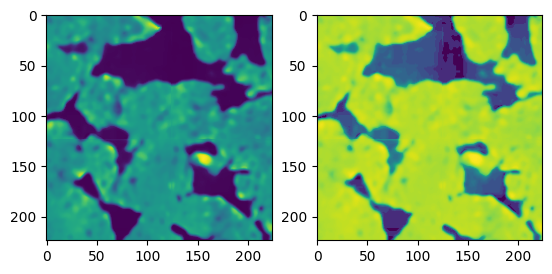

In [ ]:
from tensorflow._api.v2.compat.v1 import imag
#@title ## **Volume import**
#@markdown &lArr; _**Press the triangle to run this cell after setting the parameter(s)**_

#@markdown `name_stack` : set stack names using square brackets and commas, like this: _\["example1", "example2"\]_.
name_stack = ["test_alhammadi"] # @param {type:"raw"}
name_stack = remove_spaces_from_list(name_stack)

stackImage = []
stackLabel = []

for image in name_stack:
  mask = image + '/masks'
  image = image + '/images'
  A_image = Stack(name = 'images',
                imageType = imageType,
                isSegmented = False,
                width = img_width,
                height = img_height,
                numSlice = num_sample,
                path = os.path.join(data_dir, image))
  stackImage.append(A_image)

  A_mask = Stack(name='masks',
                isSegmented = True,
                width=img_width,
                height=img_height,
                stackImage = A_image,
                selectedFiles = A_image.getSelectedFiles(),
                path = os.path.join(data_dir, mask))
  stackLabel.append(A_mask)

util = Util(name = "batch test",
            validation_split=val_split,
            image_preprocessing_functions = image_preprocessing_functions,
            stackImage = stackImage,
            stackLabel = stackLabel)
Xtrain, Ytrain, Xtest, Ytest = util.loadData()

Xtrain - Min: 0.0
Xtrain - Max: 1.0
Xtest - Min: 0.0
Xtest - Max: 1.0
Ytrain - Min: 0.0
Ytrain - Max: 1.0
Ytest - Min: 0.0
Ytest - Max: 1.0
[(255, 0, 0), (0, 255, 255)]
Class Counts:
Class 0: 1270408 samples
Class 255: 3747192 samples


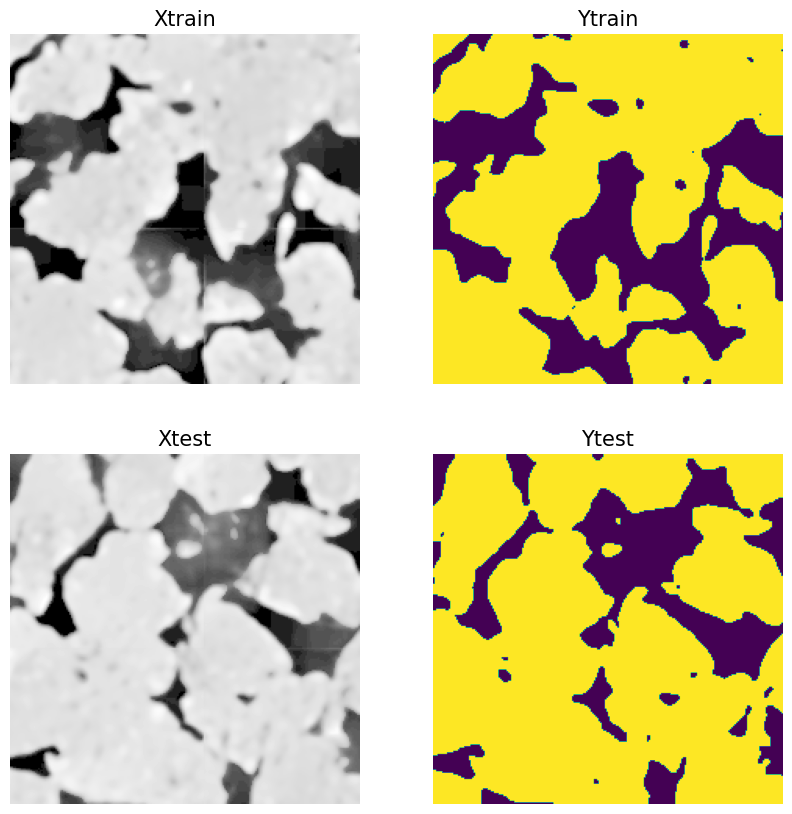

In [ ]:
#@title ## **2nd visual check (optional)**
#@markdown &lArr; _**Press the triangle to run this cell**_

# Print the minimum and maximum values of Xtrain
print("Xtrain - Min:", np.min(Xtrain))
print("Xtrain - Max:", np.max(Xtrain))

# Print the minimum and maximum values of Xtest
print("Xtest - Min:", np.min(Xtest))
print("Xtest - Max:", np.max(Xtest))

# Print the minimum and maximum values of Ytrain
print("Ytrain - Min:", np.min(Ytrain))
print("Ytrain - Max:", np.max(Ytrain))

# Print the minimum and maximum values of Ytest
print("Ytest - Min:", np.min(Ytest))
print("Ytest - Max:", np.max(Ytest))
N_class = stackImage[0].getNumClass()
custom_colors = generate_colors(N_class)
print(custom_colors)

custom_cmap = ListedColormap(custom_colors)

i = random.randint(0, len(Xtest)-1)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(Xtrain[i], cmap='gray')
axes[0,0].set_title('Xtrain', fontsize=15)
axes[0,0].axis('off')
if N_class <= 2:
    axes[0,1].imshow(Ytrain[i])
else:
    axes[0,1].imshow(np.argmax(Ytrain[i], axis=-1))
axes[0,1].set_title('Ytrain', fontsize=15)
axes[0,1].axis('off')
axes[1,0].imshow(Xtest[i], cmap='gray')
axes[1,0].set_title('Xtest', fontsize=15)
axes[1,0].axis('off')
if N_class <= 2:
    axes[1,1].imshow(Ytest[i])
else:
    axes[1,1].imshow(np.argmax(Ytest[i], axis=-1))
axes[1,1].set_title('Ytest', fontsize=15)
axes[1,1].axis('off')

def compute_class_counts(labels):
    """
    Compute the total count of each class in the list of labels and print the results.

    Args:
    labels (list or numpy array): List of class labels.
    """
    unique_classes, class_counts = np.unique(labels, return_counts=True)


    print("Class Counts:")
    for class_label, count in zip(unique_classes, class_counts):
        print(f"Class {class_label}: {count} samples")

compute_class_counts(stackLabel[0].getListSlice())

In [ ]:
#@title ## **Model training**
#@markdown &lArr; _**Press the triangle to run this cell**_

neuralNetwork = ResUNet(pathLogDir = runs_dir,
                        featuremaps = featuremaps,
                        data=util,
                        epochs = epochs,
                        batch_size = batch_size,
                        learningRate = learningRate,
                        L2=L2,
                        batchNorm = batchNorm,
                        maxNorm = maxNorm,
                        dropOut= dropOut,
                        dropOutRate = dropOutRate,
                        metrics = metrics,
                        early_stopping = early_stopping,
                        loss_early_stopping = loss_early_stopping,
                        #dataGeneration=False,
                        #additional_augmentation_factor=5,
                        patience=patience,
                        padding = "same",
                        pretrained = True,
                        backbone = backbone,
                        save_model = True,
                        displaySummary = displaySummary)

neuralNetwork.setModel()

neuralNetwork.run(forVisualisation=False)

# **Inference**

In [ ]:
#@title ##**Settings**
#@markdown &lArr; _**Press the triangle to run this cell, after setting the parameters**_

import sys
import os
!pip install -U -q segmentation-models --user

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if 'google.colab' in sys.modules:
    # Google Colab environment
    from google.colab import drive
    drive.mount('/content/gdrive')
    # Get the path to your project directory
    project_dir = '/content/gdrive/MyDrive/Schism/'
    sys.path.append(os.path.join(project_dir, "code/10-11-23-AC/"))
else:
    # Define the project directory (one level up from the current directory)
    project_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    sys.path.append(os.path.join(project_dir, "code"))

runs_dir = os.path.join(project_dir, 'runs')
data_dir = os.path.join(project_dir, 'data')

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from classes.stack import Stack
from classes.resUNet import ResUNet
from classes.util import Util
import keras
from classes.clr_callback  import CyclicLR
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import cv2
from tensorboard import program
import pandas as pd
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras import backend as K
from matplotlib.colors import ListedColormap
import random
import colorsys
from joblib import load
from tensorflow.keras.models import model_from_json

def generate_prediction(model, image_array, numClass):
    predictions = model.predict(image_array)
    if numClass == 2:
        Ypred_threshold = (predictions >= 0.5).astype(int)
    else:
        Ypred_threshold = np.argmax(predictions, axis=-1)

    return Ypred_threshold

def generate_colors(N_class):
    # Ensure there's at least one class
    N_class = max(N_class, 1)

    # Generate colors evenly distributed in the color space
    hsv_colors = [(x / N_class, 1, 1) for x in range(N_class)]

    # Convert HSV colors to RGB
    rgb_colors = [tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*hsv)) for hsv in hsv_colors]

    return rgb_colors

def get_parameters_from_log_file(log_file_path):
    """
    Reads a log.txt file and generates a list of parameters that are included in the log.txt.
    Args:     log_file_path: The path to the log.txt file.
    Returns:     A list of parameters that are included in the log.txt file.
    """
    parameters = {}
    with open(log_file_path,"r") as log_file:
        for line in log_file:
            if 'Informational inputs' in line :
                break
            line = line.strip()      # Skip empty lines and comments.
            if line and not line.startswith("#"):
                # Split the line into the parameter name and value.
                line_split = line.split(" = ")
                if len(line_split) >= 2:
                    parameter_name, parameter_value = line_split[0],line_split[1]
                    # Strip whitespace from the parameter name and value.
                    parameter_name = parameter_name.strip()
                    parameter_value = parameter_value.strip()
                    # Add the parameter to the list of parameters.
                    if parameter_name == 'image_preprocessing_functions' or parameter_name == 'metrics':
                        parameter_value = parameter_value.rstrip(']')
                        parameter_value = parameter_value.lstrip('[')
                        parameter_value = parameter_value.replace('\'','')
                        parameter_value = parameter_value.split(',')
                    parameters[parameter_name] = parameter_value
    return parameters

def remove_spaces_from_list(word_list):
    return [word.replace(" ", "") for word in word_list]

#@markdown `run_name`: set the file name for the trained model.
run_name = "binary-pred-demo" # @param {type:"string"}

#@markdown `num_sample` : set the number of slices. If set to _None_, all images will be selected.
num_sample = 10 #@param {type:"integer"}

#@markdown `name_stack` : set stack names using square brackets and commas, like this: _\["example1", "example2"\]_.
name_stack = ["bentheimer_testing"] # @param {type:"raw"}
name_stack = remove_spaces_from_list(name_stack)

#@markdown `real_inference` : tick the box to perform inference without ground truth data. Untick the box if ground truth data is available.
real_inference = False #@param {type:"boolean"}

file_dict = get_parameters_from_log_file(os.path.join(runs_dir, run_name,'logs.txt'))
imageType = int(file_dict['imageType'])
img_width, img_height = int(file_dict['img_width']), int(file_dict['img_height'])
scaler = load(os.path.join(runs_dir, run_name, 'std_scaler_image.bin')) # Data scaler loading
model_path = os.path.join(runs_dir, run_name, 'weights')
json_file = open(os.path.join(model_path, 'weights.json')  , 'r') # Load the model architecture from JSON file
loaded_model_json = json_file.read() # Read the JSON file
json_file.close() # Close the JSON file
loaded_model = model_from_json(loaded_model_json) # Load the model architecture
loaded_model.load_weights(os.path.join(model_path, 'weights.h5')) # Load the model weights and apply them to the model
pretrained = bool(file_dict["pretrained"])
numClass = int(file_dict["numClass"])
image_preprocessing_functions = file_dict["image_preprocessing_functions"]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


 100% ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ - [Stack- Loading images]
 100% ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ - [Stack- Loading masks]
 100% ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ - [- Loading batch testing][0.7325103759765625, 0.2674896240234375]

adjust log


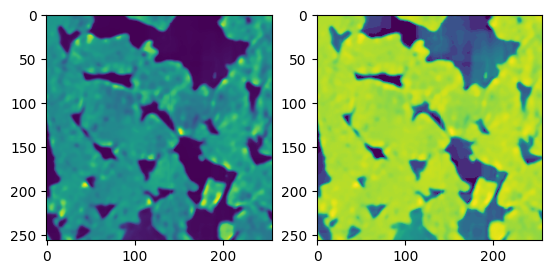

1/1 [==============================] - 1s 1s/step


In [ ]:
#@title ##**Scanner loading & preprocessing**
#@markdown &lArr; _**Press the triangle to run this cell after setting the parameter**_

if real_inference:

    stackImage = []

    for images in name_stack:
      images = images + '/images'
      ImagesPred = Stack(name='images',
                      imageType = imageType,
                      isSegmented=False,
                      width=img_width,
                      height=img_height,
                      numSlice=num_sample,
                      path = os.path.join(data_dir, images))
      stackImage.append(ImagesPred)

    util2 = Util(name = "batch prediction",
                scaler = scaler,
                image_preprocessing_functions = image_preprocessing_functions,
                stackImage = stackImage)

    imgPred, Ytrain, Xtest, Ytest =  util2.loadData()
    if pretrained:
      if util2.getImageType() == 1:
        imgPred = np.concatenate([imgPred] * 3, axis=-1)
    Ypred_threshold = generate_prediction(loaded_model, imgPred, numClass)
else:

    stackImage = []
    stackLabel = []

    for image in name_stack:
      mask = image + '/masks'
      image = image + '/images'
      A_image = Stack(name = 'images',
                    imageType = imageType,
                    isSegmented = False,
                    width = img_width,
                    height = img_height,
                    numSlice = num_sample,
                    path = os.path.join(data_dir, image))
      stackImage.append(A_image)
      A_mask = Stack(name='masks',
                    isSegmented = True,
                    width=img_width,
                    height=img_height,
                    stackImage = A_image,
                    selectedFiles = A_image.getSelectedFiles(),
                    path = os.path.join(data_dir, mask))
      stackLabel.append(A_mask)

    '''
    Images2 = Stack(name = 'images',
                    imageType = imageType,
                    isSegmented = False,
                    width = img_width,
                    height = img_height,
                    numSlice = num_sample,
                    path = os.path.join(data_dir, 'berea/images'))

    Masks2 = Stack(name='masks',
                    isSegmented = True,
                    width=img_width,
                    height=img_height,
                    stackImage = Images2,
                    selectedFiles = Images2.getSelectedFiles(),
                    path = os.path.join(data_dir, 'berea/masks'))
    '''
    util_testing = Util(name = "batch testing",
                isInference = True,
                scaler = scaler,
                image_preprocessing_functions = image_preprocessing_functions,
                stackImage = stackImage,
                stackLabel = stackLabel)

    imgPred, maskTesting, null_variable1, null_variable2 = util_testing.loadData()
    numClass = util_testing.getNumClass()

    if pretrained:
      if util_testing.getImageType() == 1:

        imgPred = np.concatenate([imgPred] * 3, axis=-1)

    Ypred_threshold = generate_prediction(loaded_model, imgPred, numClass)

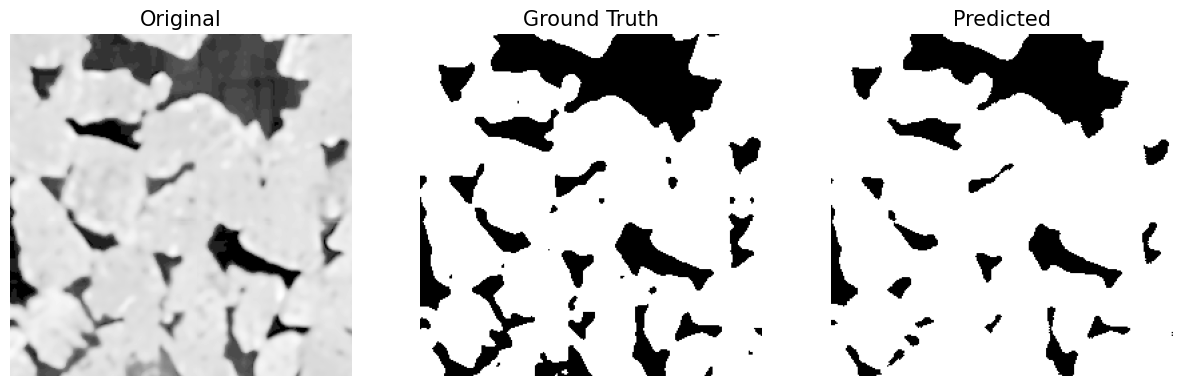

In [ ]:
#@title ## **Prediction display**
#@markdown &lArr; _**Press the triangle to run this cell**_
if real_inference:
    i = random.randint(0, len(imgPred) - 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    if numClass > 2:
        axes[0].imshow(imgPred[i])  # Use Xtest[i] for test images
    else:
        axes[0].imshow(imgPred[i], cmap='gray')  # Use Xtest[i] for test images
    axes[0].set_title('Original', fontsize=15)
    axes[0].axis('off')

    if numClass > 2:
      predicted_cmap = plt.cm.get_cmap('viridis', numClass)  # Choose your colormap
      #axes[2].imshow(np.argmax(Ypred_threshold[i], axis=-1), cmap=predicted_cmap, vmin=0, vmax=numClass - 1)
      #color_image = Ypred_threshold[i].reshape(imgPred.shape[1], imgPred.shape[2], imgPred.shape[3])
      axes[1].imshow(Ypred_threshold[i], cmap=predicted_cmap, vmin=0, vmax=numClass - 1)
      axes[1].set_title('Predicted', fontsize=15)
      axes[1].axis('off')
    else:
      binary_predictions = Ypred_threshold[i].squeeze()  # Assuming predictions is of shape (num_samples, height, width, 1) for binary
      axes[1].imshow(binary_predictions, cmap='gray', vmin=0, vmax=1)  # Binary images have values 0 or 1
      axes[1].set_title('Predicted', fontsize=15)
      axes[1].axis('off')
else:
    i = random.randint(0, len(imgPred) - 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(imgPred[i], cmap='gray')  # Use Xtest[i] for test images
    axes[0].set_title('Original', fontsize=15)
    axes[0].axis('off')

    if numClass > 2:
      ground_truth_mask = maskTesting[i].argmax(axis=-1)  # Use Ytest[i] for test masks
      ground_truth_cmap = plt.cm.get_cmap('viridis', numClass)  # Choose your colormap
      axes[1].imshow(ground_truth_mask, cmap=ground_truth_cmap, vmin=0, vmax=numClass - 1)
      axes[1].set_title('Ground Truth', fontsize=15)
      axes[1].axis('off')

      predicted_cmap = plt.cm.get_cmap('viridis', numClass)  # Choose your colormap
      #axes[2].imshow(np.argmax(Ypred_threshold[i], axis=-1), cmap=predicted_cmap, vmin=0, vmax=numClass - 1)
      color_image = Ypred_threshold[i].reshape(imgPred.shape[1], imgPred.shape[2], 1)
      axes[2].imshow(color_image, cmap=predicted_cmap, vmin=0, vmax=numClass - 1)
      axes[2].set_title('Predicted', fontsize=15)
      axes[2].axis('off')
    else:
      binary_ground_truth = maskTesting[i].squeeze()  # Use Ytest[i] for test masks
      axes[1].imshow(binary_ground_truth, cmap='gray', vmin=0, vmax=1)  # Binary images have values 0 or 1
      axes[1].set_title('Ground Truth', fontsize=15)
      axes[1].axis('off')

      binary_predictions = Ypred_threshold[i].squeeze()  # Assuming predictions is of shape (num_samples, height, width, 1) for binary
      axes[2].imshow(binary_predictions, cmap='gray', vmin=0, vmax=1)  # Binary images have values 0 or 1
      axes[2].set_title('Predicted', fontsize=15)
      axes[2].axis('off')